In [553]:
from IPython.display import HTML

hide_me = ''
HTML('''<script>
code_show=true; 
function code_toggle() {
  if (code_show) {
    $('div.input').each(function(id) {
      el = $(this).find('.cm-variable:first');
      if (id == 0 || el.text() == 'hide_me') {
        $(this).hide();
      }
    });
    $('div.output_prompt').css('opacity', 0);
  } else {
    $('div.input').each(function(id) {
      $(this).show();
    });
    $('div.output_prompt').css('opacity', 1);
  }
  code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input style="opacity:0" type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [ ]:
# <script>
#   function code_toggle() {
#     if (code_shown){
#       $('div.input').hide('500');
#       $('#toggleButton').val('Show Code')
#     } else {
#       $('div.input').show('500');
#       $('#toggleButton').val('Hide Code')
#     }
#     code_shown = !code_shown
#   }

#   $( document ).ready(function(){
#     code_shown=false;
#     $('div.input').hide()
#   });
# </script>
# <form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

# The Ultimate Case Study - Analysis of a Fictional Ride-Sharing Service

**NOTE:** Code is available within this notebook by clicking on the show code button in the upper left hand corner.

> #### Part 1 ‑ Exploratory data analysis
> The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15-minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [34]:
%%capture
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import missingno
import json
from fancyimpute import KNN

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import SGDClassifier as SGD
from sklearn.metrics import roc_curve

%matplotlib inline

In [35]:
logins = pd.read_json('data/logins.json')

#### The Data
At a glance. Number of observations, features, datatypes and non-null values.

In [36]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


Earliest and latest logins recorded.

In [37]:
logins.login_time.min(), logins.login_time.max()

(Timestamp('1970-01-01 20:12:16'), Timestamp('1970-04-13 18:57:38'))

Unique login times.

In [38]:
logins.nunique()

login_time    92265
dtype: int64

About 900 repeat login times, identical to the second. Check that this isn't missing data masquerading by another identifier (like 00:00:00).

In [39]:
logins.login_time.value_counts().head()

1970-02-12 11:16:53    3
1970-02-24 23:09:57    3
1970-03-29 03:24:57    3
1970-03-14 17:45:52    3
1970-01-09 01:31:25    3
Name: login_time, dtype: int64

Okay, just coincidental.

---

### Group Logins

Count the number of logins for each 15 minute interval.

In [40]:
logins['users'] = 1  # So groupby has something to count.
logins_15 = logins.set_index('login_time').groupby(pd.TimeGrouper('15Min')).count()
logins_15.head()

,users
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


## Exploratory Data Analysis

First step is to examine the distribution of login counts as well as how the counts change over time.

In [41]:
def view_counts(df, freq, b=40, scale_hist = True, format_xticks = True):
    plt.figure(figsize=(12,4))
    ax = plt.subplot2grid((1, 3), (0, 0))
    ax.hist(df.users, bins=b, **{'log':scale_hist})
    if scale_hist:
        ax.set_title('Distribution of Login Counts (log scale)')
    else:
        ax.set_title('Distribution of Login Counts')
    ax.set_xlabel('Login Counts per ' + freq + ' Period')

    ay = plt.subplot2grid((1, 3), (0, 1), colspan=2)
    ay.plot(df.index, df.users)
    ay.set_title('Number of ' + freq + ' Logins Over Time')
    if format_xticks:
        ay.xaxis.set_major_formatter(mdates.DateFormatter("%b %d (%a)"))
        plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()

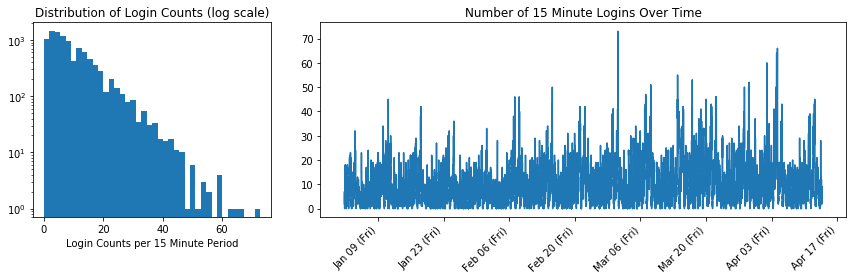

In [42]:
view_counts(logins_15, '15 Minute')

The histogram above shows how often a range of login counts appeared. Key observations:
- There were about a thousand 15 minute periods where one or two users logged in.
- About a hundred periods where ~30 users logged in.
- Only a dozen or so periods where 50+ users logged in.

The time series plot shows:
- Activity spikes during the weekend.
- Weekly dips after the weekend.
- Huge spike in early march. Perhaps from a promotional event?

There doesn't appear to be a trend over time from looking at the 15 minute spans, but worth checking larger increments.

### Daily Logins

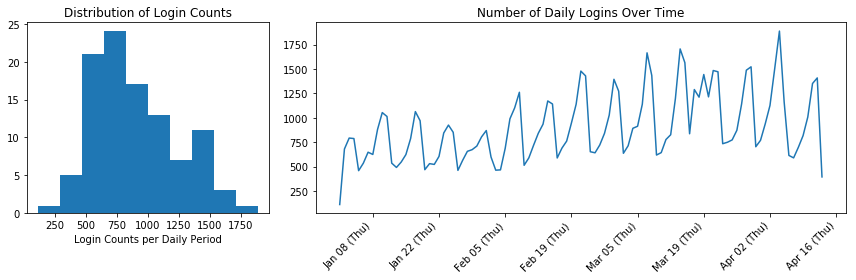

In [43]:
logins_D = logins.set_index('login_time').groupby(pd.TimeGrouper('1D')).count()\
                            .mean(axis=1).to_frame().rename(columns = {0:'users'})

view_counts(logins_D, 'Daily', b= 10, scale_hist=False)

It was absolutely looking at this in finer detail. The weekend spikes and early week dips are still visible as is a rise in daily activity over time.

From the histogram, the distribution appears bimodal - meaning there are 2 very common ranges for daily logins:
- Regular days tend to have between 500 and 1100 logins.
- High usage days have between 1300 and 1600 logins.

A strong distinction between weekend and weekday activity has appeared in both plots, so it's worth looking at closer.

####  Day of the Week Logins

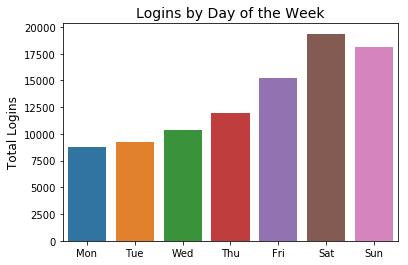

In [44]:
logins_dow = logins.set_index('login_time')
logins_dow = logins_dow.groupby(logins_dow.index.weekday_name).count()
logins_dow['weekday'] = logins_dow.index
logins_dow = logins_dow.iloc[[1,5,6,4,0,2,3]]  # ugly brute-force sort to avoid
                                               # categorical conversions
    
sns.barplot(logins_dow.weekday.apply(lambda x: x[:3]), logins_dow.users)
plt.title('Logins by Day of the Week', fontsize = 14)
plt.ylabel('Total Logins', fontsize = 12)
plt.xlabel('')

This reveals a pretty clear trend. Logins grow steadily over the week, peak on Saturday, take a slight drop Sunday, and plummet Monday.

One last frequency to check.

#### Hourly Logins

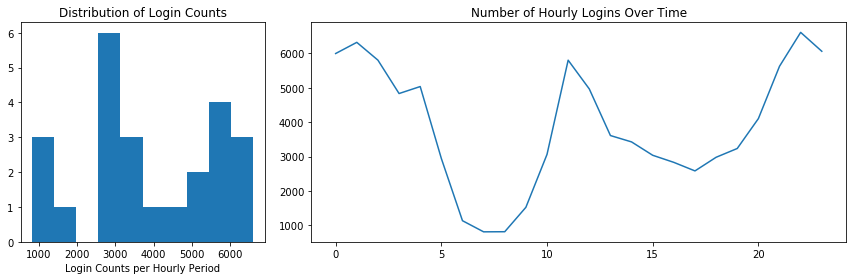

In [45]:
logins_hr = logins.set_index('login_time')
logins_hr = logins_hr.groupby(logins_hr.index.hour).count()
view_counts(logins_hr, 'Hourly',b= 10, scale_hist= False, format_xticks= False)

---

## Conclusions

- Activity has been steadily growing over the last three and a half months.
- Users are **very** active on weekends, **less** active early in the week.
- 2 major daily activity periods:
    - Lunch (11 am - 1 pm)
    - Early to late night (9 pm - 4 am)
    - **Of note**: Sharp drop in activity almost precisely at 4 am. Perhaps this is when bars are required to stop serving?
    

---    
> ### Part 2 ‑ Experiment and metrics design
> The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
> 1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
> 2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:

>> a. how you will implement the experiment
    
>> b. what statistical test(s) you will conduct to verify the significance of the
observation

>> c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

## Problem Interpretation:

It is important to first define what the exact problem is:  
$\qquad$An undesired equilibrium (drivers not adjusting to rider demand) has formed between the driver pools of the two cities due to an artificial barrier (the tolls). This undesired equilibrium is problematic to Ultimate for a few reasons:
- It obstructs otherwise available revenue streams (riders that choose not to use Ultimate due to long wait times or surge prices).
- It lowers rider satisfaction (for the aforementioned reasons), which results in diminished future revenues from rider abandonment.
- It lowers driver satisfaction and engagement, which creates a **cascading problem**:  
$\qquad$Long wait times $\rightarrow$ Riders using Ultimate less $\rightarrow$ Fewer fares for drivers $\rightarrow$ Fewer drivers $\rightarrow$ Longer wait times $\rightarrow \infty_{regress}$

**But** the problem is not the toll. The problem is the lack of a desirable equilibrium. Therefore, paying for all tolls does not inherently solve the problem. The solution is to help a better equilibrium form. This can be accomplished several ways:
- Paying for all tolls during transition periods (weekday mornings and evenings).
- Paying for some drivers' tolls (eg, drivers that could be incentivized to move into the other city for their shift for the price difference of two-way toll fare).
- Paying for all tolls.

That last soltuion is by far the most expensive. If nearly the same equilibrium can be achieved with one (or both) of the other solutions, there is no reason to adopt the third.

**Alternative Solution**: There is another way Ultimate might look to lessen this problem without paying for tolls - *reverse-surge pricing*. If Ultimate offered substantially discounted or break-even rates for rides during transition periods (Gothom to Metropolis in the morning and the other way around in the evening), then drivers could naturally switch between the two cities to create a better equilibrium without Ultimate having to pay anything extra.

## Solution

There are three key metrics to consider:
- Change in average wait time
- Change in Ultimate revenue
- Total toll cost

Ideally, all three would be used because they all have seperate benefits. Revenue gives a measure of how many more rides are being purchased. Wait time gives a measure of user satisfaction. Toll cost gives a measure of how many drivers are making use of the offer **and** if the experiment is successful, allows Ultimate to know what their ceiling would be in a negotiation with the toll's regulatory body for a discounted bulk rate.

If only one metric can be used, it would ideally be a combination of all three, such as:

$$\max \frac {\Delta p}{\Delta t}$$

where $\Delta p$ is % change in Ultimate's Gotham and Metropolis profit (including toll reimbursement) from test group drivers, and $\Delta t$ is % change in average wait time. Call the metric profit by weight (pbw). Increases in profit and decreases in weight time are both accounted for.

#### Experiment

There are several ways to run with this:
1. **Toll Elimination (Toll-tal Recall? No? Okay, fine.)**: Reimburse all tolls paid by all drivers for a fixed period. Whether the driver crossed the bridge once or fifty times a week.
2. **Toll Reduction**: Similar to 1. but only reimburse at most 2 tolls per driver per weekday.
2. **A/B Test on Cities**:  Offer to reimburse up to 2 tolls per weekday for all drivers that normally drive in Gotham.
3. **A/B/C Test**: Break option 4. into 2 different, simultaneous offers. Offer Gother drivers the reimbursement Monday, Wednesday, Friday one week and Metropolis drivers Tuesday and Thursday (over 36 hour period for Metropolis drivers, since they are being pulled into overnight shifts). Switch the offers around the other way each week or every two weeks.

The ideal solution requires some level of domain knowledge. It would be great if historical data for the same time period in previous years could be used as the control group as this would allow for a simpler experiment like option 2. But I do not know the scope of Ultimate's records, or if measures affecting my metric have changed over time (eg, profit margins used to be smaller and weight times longer).

It's also hard to know how comparable two adjacent time periods actually are to each other if the time period before the promotion were to be used as the control. One week might naturally have higher or lower activity than the one proceeding it (like if there's a big event in one of the cities).

These reasons make options 1 and 2 difficult to test with certainty. Option 3 offers a clear test and control group - the two cities. The one where drivers received the offer is the control (because those drivers are the ones being given the chance to operate in the other city). The only catch here is that this offer might make the control city perform artificially worse if drivers change their schedule and stop driving there completely.

Option 4 is the one I would implement. It's the most complicated unfortunately, but it also provides multiple referrence points for comparison and is able to use each city as both test and control so it is robust to activity spikes from events. On top of that, because one group drives overnight, there would actually be shifts during the experiment where neither city was receiving the promotion, so there would be pure control points within the experiment (this handles the problem with option 3).

#### Validation

Perform several 2 sample t tests:

City With Promotion |Test Group | Control Group
--- | --- | ---
Metropolis | Gotham | Metropolis
Gotham | Metropolis | Gotham
Neither | All Other Test Periods | Current Activity
Metropolis | Current Gotham | Promotion Period Gotham
Gotham | Current Metropolis | Promotion Period Metropolis

Above tests can be performed during each point where state exists or aggregations of experimental states. However, an $\alpha$ correction must be included for each additional hypothesis test performed.

#### Results

If the results were all positive ($pbw > 1$) and t tests show that improvement in metric is not due to chance at desired $\alpha$, I would recommend that the reimbursements promotion period be extended and the offer given all weekdays to both cities but to a limited number of drivers (based on driver activity during experiment) so as to not overcorrect the equilibrium and not overpay.

If the results were non-uniformly positive, if say Gotham drivers took to it and lead to positive changes in Metropolis but not the other way around, I would recommend extending the promotion for Gotham drivers and conducting another experiment on how to incentivize Metropolis drivers.

**Caveats**: I feel the design of this experiment helps to safeguard it against the biases that endanger the alternatives, but its complexity is problematic. The constant back and forth of who has what promo when could really put off and confuse drivers, reducing the adoption of the promotion and thereby the effectiveness of the experiment as well.

---
> ## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

> ## Data description

> - city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday

In [46]:
with open('data/ultimate_data_challenge.json') as f:
    df = pd.DataFrame(json.load(f))

### Data Examination and Cleaning

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


There are a few features with missing values. There are also 2 datetime features improperly encoded as string objects that must be corrected.

In [48]:
feats = ['last_trip_date','signup_date']
pd.DataFrame({'feature':feats,
              'type':[type(df[f][0]) for f in feats],
             'example':[df[f][0] for f in feats]}).set_index('feature')

,example,type
feature,,
last_trip_date,2014-06-17,<class 'str'>
signup_date,2014-01-25,<class 'str'>


In [49]:
for f in feats:
    df[f] = pd.to_datetime(df[f])

The index of this data is the effective user id. Since there is no other unique identifier in the features (and the size of the data is not prohibitively large), it should be added to the feature space as a precaution in case it is lost later in any sort of reindexing operation.

In [50]:
df['user_id'] = df.index

`phone` and `city` are categorical features which will need to be represented numerically. Also, because `phone` has missing values, extra care should be taken to retain that information.

In [51]:
df = pd.get_dummies(df, columns=['city','phone'], prefix=['city','phone'], dummy_na=True)
df.loc[df.phone_nan == 1, ['phone_Android', 'phone_iPhone']] = None
df.drop(['city_nan', 'phone_nan'], axis=1, inplace=True)

`ultimate_black_user` as a boolean should naturally coerce to 1/0 by most classifier models, but just to be safe I'll change it to an int.

In [143]:
df['ultimate_black_user'] = df.ultimate_black_user.astype(int)

Lastly, since datetime objects don't always play nicely with machine learning algorithms, another feature, `signup_day` should be created from `signup_date`.

In [52]:
df['signup_day'] = df.signup_date.dt.day

### Missing Values

Missing values must be examined for patterns and relationships before being dealt with. Use graphical and numeric examination to see if values are:
- Missing Completely At Random (MCAR)
- Missing Not At Random (MNAR)
- Missing At Random (MAR)

First, examine proportions of missing values.

In [53]:
def missing_values_table(df, summarize = None):
    '''
    Returns a dataframe that shows the number and percent of present and missing values
    as features, indexed by the columns of df.
    
    Parameters
    ---------
    df: pandas DataFrame
    
    summarize: str
        Allows for summation of reporting by eliminating columns with all missing values,
        all present values, or both from the returned table.
        ('full', 'empty', or 'both')
    
    '''
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    vals = df.notnull().sum()
    val_percent = 100 * vals / len(df)
    missing_table = pd.concat([missing, missing_percent, vals, val_percent], axis=1) \
    .rename(columns = {0 : 'missing', 1 : 'missing_percent', 2:'vals',3:'value_percent'})
    
    empty = pd.Series([True for c in df.columns], index=df.columns)
    full = empty.copy()
    
    if summarize in ['empty','both']:
        empty = missing_table[missing_table.vals == 0].index
        print(len(empty),'Columns with no values: ', list(empty))
        empty = missing_table.vals > 0
    if summarize in ['full','both']:
        full = missing_table[missing_table.missing == 0].index
        print('\n',len(full),'columns with all values present: ',list(full))
        full = missing_table.missing > 0

    return missing_table[(empty) & (full)]


In [54]:
missing_values_table(df, 'both')

0 Columns with no values:  []

 13 columns with all values present:  ['avg_dist', 'avg_surge', 'last_trip_date', 'signup_date', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'user_id', 'city_Astapor', "city_King's Landing", 'city_Winterfell', 'signup_day']


,missing,missing_percent,vals,value_percent
avg_rating_by_driver,201,0.402,49799,99.598
avg_rating_of_driver,8122,16.244,41878,83.756
phone_Android,396,0.792,49604,99.208
phone_iPhone,396,0.792,49604,99.208


There is a non-ignoreable percentage of missing values in average rating of driver. Since this feature is an average of all the user's reviews there are two possibilities for why these values are missing:
- Error in database grouping transformations (1 missing value caused the average to become a missing value).
- These users never gave any reviews.

If the former is the case, these values are MCAR. But, if the latter possibility is the case then this feature is MNAR - the missing values are providing information about the observation. These are users that don't review. Simply filling those missing values would lose an important piece of structure in the data. However, leaving the values missing would prevent most modeling algorithms from functioning.

**Solution:** Proceed as if MNAR and add another feature before imputing - *no_reviews* - a binary feature that is 1 for users with missing values on avg driver review, and 0 for all other users.

There is no way of knowing which possibility is the case, but if the feature is MCAR no relationship between the target and this derived feature will be noticeable in the final analyis. Better to have useless data than unneccessarily ignore useful data.

Next, examine the relationship of the missing values to other features.

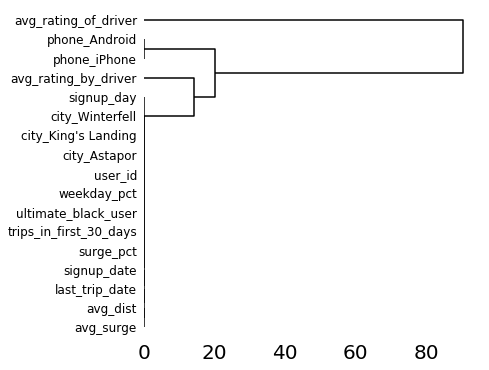

In [55]:
missingno.dendrogram(df, orientation='right',figsize=(6,6), fontsize=12)

Interesting. The other features with missing values are the `phone` dummies and `avg_rating_by_driver`. Their proximity on the dendrogram indicates that there is some relationship between their nullity, while avg_rating_of_driver is not explained by any of the other features. `phone`'s dummies and `avg_rating_by_driver` will therefore be assumed MAR.

In [66]:
def describe_difference(data, feat, plot_means = True, get_table = False, title_feat = None):
    if not title_feat:
        title_feat = feat
    df_scale = data.drop(['last_trip_date','signup_date'], axis =1).copy()
    mu = df_scale.mean()
    sd = df_scale.std()
    for c in df_scale.columns:
        df_scale[c] = (df_scale[c] - mu[c])/sd[c]
    sub_df = df_scale[df_scale[feat].isnull()].copy()
    diff_df = sub_df.describe() - df_scale.describe()
    if plot_means:
        diff_df.loc['mean',:].plot(kind = 'barh', figsize = (8,5))
        plt.xlabel('Units of Standard Deviation')
        plt.title('Riders with Null {} VS All Other Riders'.format(title_feat), fontsize = 15)
        plt.tight_layout()
        plt.show()
    if get_table:
        return diff_df

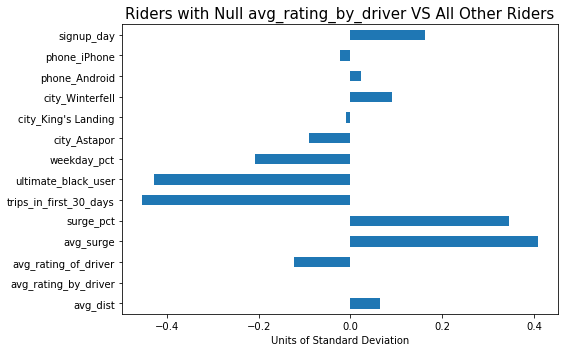

In [67]:
describe_difference(df.drop('user_id', axis=1), 'avg_rating_by_driver')

Indeed, riders not rated by the driver are very different. They took fewer first month trips, rarely used Ultimate Black, and the trips the did take were heavily surge priced. Those features all tell a pretty clear story: These riders likely are not very active if at all, only using Ultimate by necessity during surge periods. They don't have ratings likely by chance, because if they only take a few trips their drivers may happen to not have rated them.

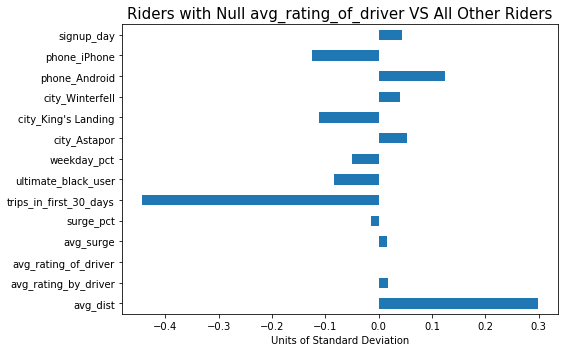

In [68]:
describe_difference(df.drop('user_id', axis=1), 'avg_rating_of_driver')

Again, there is a story to why the values are missing. These are users that take long (and likely expensive) trips very seldomly. It also so happens that more of these users were on Android than iPhone.

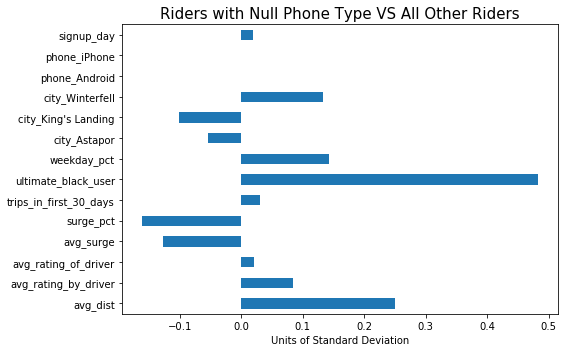

In [69]:
describe_difference(df.drop('user_id', axis=1), 'phone_iPhone', title_feat='Phone Type')

Hard to see a story here. These users often tried Ultimate Black in their first month and travelled slightly larger distances, but are otherwise very similar to regular users.

This may require some domain knowledge. Can Ultimate rides be booked without a phone? If so, it may be possible that these are business travellers for whom rides were booked by a third party.

### Imputation

Armed with this new information on why features are missing, it would be a waste of important information to blindly impute with mean or median, and regardless of the method chosen, this original nullity should be recorded.

Three index features will be added to remember where each feature had missing values in case this information is relevant down the pipeline.

In [96]:
df['no_driver_rating'] = 0
df.loc[df.avg_rating_of_driver.isnull(), 'no_driver_rating'] = 1
df['no_phone'] = 0
df.loc[df.phone_iPhone.isnull(), 'no_phone'] = 1
df['no_rider_rating'] = 0
df.loc[df.avg_rating_by_driver.isnull(), 'no_rider_rating'] = 1

Missing phone values will be treated as if it is possible to book without a phone. Since phone has been one-hot encoded, this simply means filling the missing values of both features with 0.

In [97]:
df = df.fillna({'phone_Android':0, 'phone_iPhone':0})

Because there are such strong relationships indicated by the nullity of the features, it makes sense to use an imputer for the driver/rider ratings that can preserve those relationships rather than distort them, such as KNN, MICE, SVD, etc.

This analysis will use KNN since the data is fairly long at 50k observations, there should be more than an adequate number of similar points to predict missing ones. Because the data is on the skinny side, there are fewer possible combinations of features with similar distances for missing points, so a low k should be okay. k = 11 will be used.

Because 50k observations is a bit on the large side for knn on a standard machine, I'll cheat down the size of the data. The barplots showed that observations with these features missing had very few trips in the first 30 days, so subsetting the data on a threshold of that feature will keep most of the neighbors for these features without forcing KNN to have to compute unneccessary distances.

Subsetting to trips $\leq 2$ should suffice. But that will still leave a fairly large dataset.

In [93]:
print('Riders who took 2 or fewer trips in first 30 days:'\
      ,df[df.trips_in_first_30_days <= 2].shape[0])

Riders who took 2 or fewer trips in first 30 days: 36900


To further reduce the size, KNN will be performed city by city under the assumption that each city subset is a representative sample of its ridership.

#### Scale Data

KNN works best when the features have been brought to scale so that different feature distances have the same meaning.

In [102]:
# Get catagoricals
cats = df.nunique()
cats = cats[cats <= 2].index

# Avoid non-numeric columns
bad_feats = ['user_id', 'signup_date', 'last_trip_date']

# Copy desired view
scale_df = df.loc[(df.trips_in_first_30_days <= 2) |\
             (df.avg_rating_by_driver.isnull()) |\
             (df.avg_rating_of_driver.isnull()),:].drop(bad_feats, axis=1).copy()

mu = scale_df.drop(cats, axis=1).mean()
sd = scale_df.drop(cats, axis=1).std()
scale_df.loc[:,scale_df.columns.drop(cats)] =\
(scale_df.loc[:,scale_df.columns.drop(cats)] - mu)/sd

In [107]:
### WARNING - THIS CAN TAKE ABOUT 5 MINUTES TO RUN
cities = ["city_King's Landing", "city_Astapor", "city_Winterfell"]

for city in cities:
    scale_df.loc[scale_df[city] == 1,:] = \
    KNN(11, verbose = False).complete(scale_df.loc[scale_df[city] == 1,:])

In [114]:
# import pickle
# p = open("fill_scale_df.pickle","wb")
# pickle.dump(scale_df, p)
# p.close()

Now to check the results.

In [115]:
missing_values_table(scale_df,'both')

0 Columns with no values:  []

 17 columns with all values present:  ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct', 'city_Astapor', "city_King's Landing", 'city_Winterfell', 'phone_Android', 'phone_iPhone', 'signup_day', 'no_driver_rating', 'no_phone', 'no_rider_rating']


,missing,missing_percent,vals,value_percent


Excellent. Now to rescale and fill the missing values of the original data.

In [126]:
scale_df.loc[:,scale_df.columns.drop(cats)] =\
(scale_df.loc[:,scale_df.columns.drop(cats)]*sd) + mu

df.loc[scale_df.index,['avg_rating_by_driver', 'avg_rating_of_driver']] = \
    scale_df.loc[:,['avg_rating_by_driver', 'avg_rating_of_driver']]

#### Identify Active Users

Finally, create the target variable `active`, setting it equal to 1 for any user who's last trip was within 30 days of 6 months after their signup date and 0 for all others.

Since these users all signed up in January, and Feb 2014 was not a leap year, 6 months after their signup dates will be 181 days. Within 30 days means any user whose last trip was at least 151 days after signup will be considered active.

In [139]:
df['active'] = (df.last_trip_date - df.signup_date).dt.days >= 151
df['active'] = df.active.astype(int)

## Building The Model

Time for the fun stuff!

Before testing and tuning models, I'll create a holdout set from 15% of the data.

**Note:** Also dropping one of the city features here to make interpretation easier later.

In [454]:
X, X_hold, y, y_hold = train_test_split(df.drop(['active','city_Astapor']+bad_feats,axis=1), df.active,\
                                                    test_size = 0.15, random_state=7)

Next, scale the features. It is very important that this is done AFTER the validation data has been removed, so that the scale of the data cannot give unintended clues to the values in the validation set.

In [458]:
cats = cats.drop('city_Astapor')
scaler = StandardScaler()
X.loc[:,X.columns.drop(cats)] = scaler.fit_transform(X.loc[:,X.columns.drop(cats)])

#### Feature Exploration

Before building models, it will be important to get a prelimanary sense of which features are correlated with the target and which aren't, as well as to check for signs of collinearity.

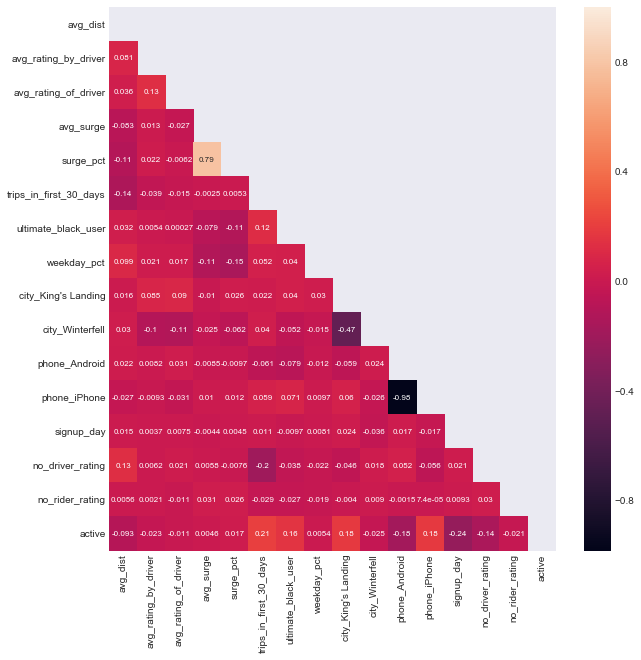

In [459]:
plt.figure(figsize=(10,10))
corr =pd.concat([X.drop('no_phone',axis=1), y],axis=1).corr()
ix =  np.zeros_like(corr)
ix[np.triu_indices_from(ix)] = True
sns.heatmap(corr, mask = ix, annot=True, annot_kws={"size": 8})

Okay, as expected the dummy features are collinear (or multicollinear technically for the cities). Normally it would make sense to drop out one dummy from each set to correct this. However the phone dummies are holding a tiny bit of information about missing phone values. So I'll hold onto all of them.

Surge percent and average surge are also very closely related. The model will need to be capable of handling such features or they will need to be combined.

Since prediction quality is only half the goal of the analyis (the other half being recommendations), I'll explore Logistic Regression (with regularization) as well as Random Forest. Random Forest should perform very well on this type of data, but Logistic Regression has the added benefit of interprettable coefficients. Both models are robust to collinearity.

**To keep in mind**: None of the features are strongly correlated with active status. There is some weak positive correlation for the number of trips in the first 30 days, ultimate black trial, iPhone use and King's Landing residence. Some weak negative correlation with signup day, android use, Astapor residence, and not having made any driver ratings (some justification for holding onto that nullity information).

### Logistic Regression

I'll see how an out of the box model performs.

In [188]:
# Split data again
X_train, X_test, y_train, y_test = train_test_split(X,y,\
                                    test_size = 0.2, random_state=7)

# Build model
lr = LogisticRegression()
lr.fit(X_train,y_train)

# Evaluate model
print('Training Accuracy: {:.3f}\nTesting Accuracy: {:.3f}'\
      .format(lr.score(X_train, y_train),lr.score(X_test, y_test)))

Training Accuracy: 0.790
Testing Accuracy: 0.784


Not bad for an out of the box regression. Next attempt will tune regularization constant, attempting on L1 and L2 norms.

In [460]:
# Build a function for repeat tuning, pray it's only needed once.
def tune_gridsearch(params, cv =5, clf = LogisticRegression(), get_clf = False):
    # Build and fit grid search
    lr_cv = GridSearchCV(clf, param_grid = params, cv=cv)
    lr_cv.fit(X,y)

    print('Best Parameters:', lr_cv.best_params_)
    print('Accuracy:', lr_cv.best_score_)
    if get_clf:
        return lr_cv

In [501]:
params = {'C': np.logspace(-5, 5, 20), 'penalty':['l1','l2']}
log_results = tune_gridsearch(params, get_clf = True)

Best Parameters: {'C': 1.8329807108324339, 'penalty': 'l1'}
Accuracy: 0.788894117647


Not any better than the out of the box. But the best parameter landed close to the center of a wide grid. There's still hope!

In [194]:
params = {'C': np.linspace(0.01, 3, 10), 'penalty':['l1','l2']}
results = tune_gridsearch(params, get_clf=True)

Best Parameters: {'C': 2.0033333333333334, 'penalty': 'l1'}
Accuracy: 0.788917647059


Even with more flexibility near the best parameters, the model isn't improving. Let's see what the wors grid search test score were. 

In [207]:
print('Lowest test score:',pd.DataFrame(results.cv_results_).mean_test_score.min())

Lowest test score: 0.787482352941


This suggest the parameters aren't going to matter. ~78.7% accuracy looks to be as good as is possible for logistic regression.

For the heck of it though, let's see what happens with an Elastic Net approach to the L1 and L2 normals.

In [280]:
sgd = SGD(loss='log', penalty='elasticnet')
params = {'alpha': np.logspace(-5,5,12), 'l1_ratio':np.linspace(.2,.8,7)}
tune_gridsearch(params, clf = sgd)

Best Parameters: {'alpha': 0.005336699231206307, 'l1_ratio': 0.40000000000000002}
Accuracy: 0.787976470588


Pretty much no difference from regular logistic regression.

I surrender. Let's see how a random forest stacks up.

### Random Forest

In [214]:
params = {'max_depth': np.arange(1,6), 'max_features':np.arange(3,16,3)}
tune_gridsearch(params, get_clf=True, clf = RF())

Best Parameters: {'max_depth': 5, 'max_features': 15}
Accuracy: 0.806588235294


Aha! Progress. Both max depth and max features are on the edges, so I'll expand the grid.

In [217]:
params = {'max_depth': np.arange(4,10), 'max_features':np.arange(13,18)}
tune_gridsearch(params, get_clf=True, clf = RF())

Best Parameters: {'max_depth': 9, 'max_features': 17}
Accuracy: 0.817647058824


Better. Should probably not go much deeper to avoid overfitting, but curious to see how much more accurate the model can get.

In [218]:
params = {'max_depth': np.arange(8,14), 'max_features':np.arange(15,18)}
rf_results = tune_gridsearch(params, get_clf=True, clf = RF())

Best Parameters: {'max_depth': 11, 'max_features': 16}
Accuracy: 0.818070588235


Okay, there's actually some convergence happening. Both optimal parameters were non-boundary, so there is no further need to tune. It would be preferrable to build the model with a lower max depth and max features, since that will give better interpretability (as well as make it less generalized). Let's see the rest of the cv results.

In [229]:
print('Lowest accuracy from Random Forest grid search was {:.3f}%.'\
      .format(np.min(rf_results.cv_results_['mean_test_score']*100)))

Lowest accuracy from Random Forest grid search was 81.035%.


Not even a full percentage point difference. But test accuracy isn't the only important metric. The model should generalize well to unseen data, which means the ideal model will have similar training and test accuracy.

Looking at the highest accuracies of the grid search shows an overfitting problem.

In [235]:
rf_grid = pd.DataFrame(rf_results.cv_results_)[['mean_test_score', 'mean_train_score', 'params']]
rf_grid.sort_values(by='mean_test_score').head()

,mean_test_score,mean_train_score,params
17,0.810353,0.909765,"{'max_depth': 13, 'max_features': 17}"
16,0.811435,0.909635,"{'max_depth': 13, 'max_features': 16}"
15,0.812165,0.909441,"{'max_depth': 13, 'max_features': 15}"
13,0.812776,0.891682,"{'max_depth': 12, 'max_features': 16}"
12,0.813482,0.890894,"{'max_depth': 12, 'max_features': 15}"


Instead let's look at parameters where test and train scores were close to each other.

In [237]:
rf_grid[rf_grid.mean_train_score - rf_grid.mean_test_score <= .025]

,mean_test_score,mean_train_score,params
0,0.815294,0.831724,"{'max_depth': 8, 'max_features': 15}"
1,0.816141,0.831876,"{'max_depth': 8, 'max_features': 16}"
2,0.814565,0.832406,"{'max_depth': 8, 'max_features': 17}"


Great. The model with the lowest max depth and max features in the search unsurprisingly has the lowest overfitting, while it's accuracy is only .3% worse than the best model. Max_depth = 8 and max_features = 15 will be used for the final model.

One last thing to check though. All the previous grid searches have assumed the gini index for evaluating splits. It's worth also considering entropy.

In [238]:
params = {'max_depth': np.arange(6,10), 'max_features':np.arange(12,16), 'criterion':['gini','entropy']}
tune_gridsearch(params, clf = RF())

Best Parameters: {'criterion': 'gini', 'max_depth': 9, 'max_features': 14}
Accuracy: 0.818164705882


Okay, similar results to before and gini index remains the preferred metric. Moving on.

### Final Model
**Random Forest**

In [542]:
rf = RF(max_depth=8,max_features=14).fit(X,y)

Let's see what features the model cared most about.

In [543]:
pd.DataFrame({'Feature':X.columns, 'Importance':rf.feature_importances_})\
.sort_values(by='Importance',ascending=False).head()

,Feature,Importance
1,avg_rating_by_driver,0.265375
12,signup_day,0.215154
4,surge_pct,0.183942
8,city_King's Landing,0.091520
7,weekday_pct,0.046448


Interestingly, the derived feature `signup_day` was considered the second most important. Unfortunately, the black-boxy nature of Random Forest makes it difficult to interpret much more than that. Also important to clarify, feature importance is non-directional - Large importance values do not mean likelier active status, only that the feature was important in predicting the outcome.

#### Logistic Regression

The regression model was not as accurate as the RF in training, but it wasn't terribly far off. However, it will provide much more interprettable coefficients. The grid search showed the best results were for L1 normal (Lasso) with regularization constant C = 2.

**But...** L1, L2, and Elastic Net results were all pretty close, so it would be fair to choose any of them. L1 has the benefit of throwing out less important features as the regularization penalty rises, while L2 merely shrinks them. It may be useful for interpretation to look at the results of all 3.

Checking over the results of the gridsearch tests, L2 performed nearly as well with a high penalty (C = 0.00428). As did the Elastic Net built earlier.

In [516]:
full_test = pd.concat([pd.DataFrame(log_results.cv_results_),\
                       pd.DataFrame(results.cv_results_)])

full_test = full_test.loc[:,['mean_test_score',\
       'mean_train_score', 'param_C', 'param_penalty',]].drop_duplicates()

full_test.sort_values(by='mean_test_score',ascending=False).head(5)

,mean_test_score,mean_train_score,param_C,param_penalty
12,0.788918,0.788882,2.00333,l1
10,0.788894,0.788900,1.67111,l1
20,0.788894,0.788876,1.83298,l1
7,0.788894,0.788882,1.00667,l2
8,0.788894,0.788865,1.33889,l1


In [515]:
full_test[full_test.param_C < .01].sort_values(by='mean_test_score',ascending=False).head(5)

,mean_test_score,mean_train_score,param_C,param_penalty
11,0.785882,0.786176,0.00428133,l2
10,0.784306,0.784676,0.00428133,l1
9,0.781035,0.781224,0.00127427,l2
7,0.770965,0.771124,0.000379269,l2
8,0.767647,0.767629,0.00127427,l1


Let's build all three!

In [523]:
# Train 3 classifiers
l2_final = LogisticRegression(penalty='l2', C = .00428).fit(X,y)
l1_final = LogisticRegression(penalty='l1', C = 2).fit(X,y)
EN_final = SGD(loss='log', penalty='elasticnet', alpha=.0053, l1_ratio=.4).fit(X,y)

In [526]:
# Bundle classifier coefficients and intercepts into a df for easy viewing.
l2 = pd.DataFrame({'L2':l2_final.coef_[0].T}, index=X.columns)
l1 = pd.DataFrame({'L1':l1_final.coef_[0].T}, index=X.columns)
EN = pd.DataFrame({'Elastic_Net':EN_final.coef_[0].T}, index=X.columns)

# Patch the coefficients into a dataframe
lr_coefs = pd.concat([l1,l2,EN],axis=1)
lr_coefs = lr_coefs\
    .append(pd.DataFrame({'L1':l1_final.intercept_,\
                          'L2':l2_final.intercept_,\
                          'Elastic_Net':EN_final.intercept_},\
                         index=['intercept']))    

# Find maximum difference between coefficients of models    
diff = lr_coefs.apply(lambda x: x.max()-x.min(),axis=1)
lr_coefs['Differences'] = diff
lr_coefs.sort_values(by='Differences', ascending=False).head(5)

,Elastic_Net,L1,L2,Differences
intercept,-2.002711,-2.263196,-1.260260,1.002936
no_rider_rating,0.000000,-0.667745,-0.053248,0.667745
phone_iPhone,0.462997,0.504622,-0.143495,0.648116
phone_Android,-0.395863,-0.492842,-0.974334,0.578472
city_King's Landing,0.995910,1.354038,0.905514,0.448523


Interesting. Right away it's clear that L2 and Elastic-Net are doing some major coefficient shrinking due to the high penalties, but in several different places.

These values are all in units of $\log_{e} odds_{\beta_{i}}$ where $\beta_{i}$ is the coefficient for feature $i$. Those kinds of values are great for the model to be built around (because they're unbounded), but not so great for interpretation. I'll convert them to probabilities and show them graphically, using the formula:

$$p_{\beta_{i}} = \frac {odds_{\beta_{i}}}{1 + odds_{\beta_{i}}} = \frac {e^{\beta_{i}}}{1 + e^{\beta_{i}}}$$

In [527]:
def l2p(x):
    o = np.exp(x)
    return o/(1+o)

lr_coefs['L1_prob'] = l2p(lr_coefs.L1)
lr_coefs['L2_prob'] = l2p(lr_coefs.L2)
lr_coefs['EN_prob'] = l2p(lr_coefs.Elastic_Net)

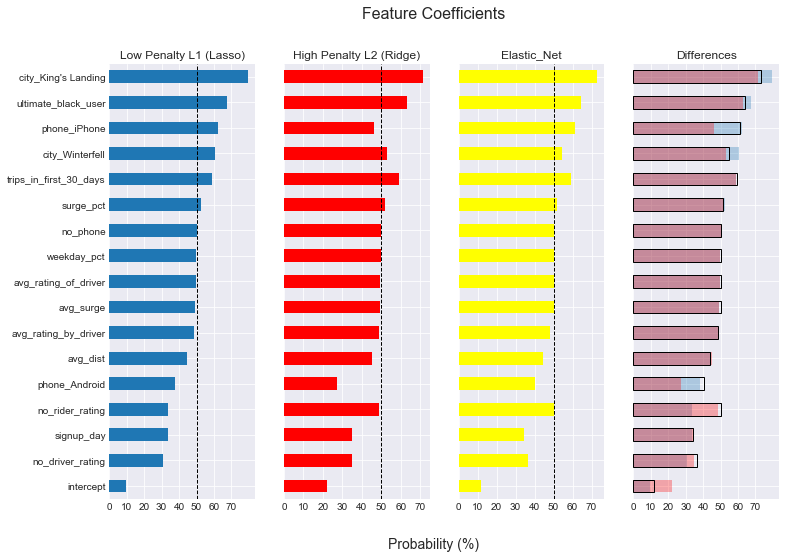

In [544]:
lr_coefs.sort_values(by='L1_prob',inplace=True)
ticks = (np.linspace(0,.7,8), [int(i) for i in np.linspace(0,70,8)])

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(12, 8))
sns.set_style('darkgrid')
plt.suptitle('Feature Coefficients', fontsize = 16)

ax1 = plt.subplot(141)
lr_coefs.L1_prob.plot(kind = "barh")
plt.title("Low Penalty L1 (Lasso)")
plt.axvline(x=.5, linestyle = '--', color = 'black', lw = 1)
plt.xticks(*ticks)

ax2 = plt.subplot(142, sharey=ax1)
lr_coefs.L2_prob.plot(kind = 'barh', color = 'red')
plt.title("High Penalty L2 (Ridge)")
plt.axvline(x=.5, linestyle = '--', color = 'black', lw = 1)
plt.xticks(*ticks)

ax3 = plt.subplot(143, sharey=ax1)
lr_coefs.EN_prob.plot(kind = 'barh', color = 'yellow')
plt.title("Elastic_Net")
plt.axvline(x=.5, linestyle = '--', color = 'black', lw = 1)
plt.xticks(*ticks)

ax4 = plt.subplot(144, sharey=ax1)
lr_coefs.L1_prob.plot(kind = "barh", alpha = .3)
lr_coefs.L2_prob.plot(kind = 'barh', color = 'red', alpha = .3)
lr_coefs.EN_prob.plot(kind = 'barh', **{'fill':False})
plt.title("Differences")
plt.xticks(*ticks)

fig.text(0.5, 0.04, 'Probability (%)', ha='center', fontsize = 14)

plt.show()

**Note** - Empty bars (sharp black lines) on the 'Differences' plot represent Elastic net.

This is easier to interpret. The bars here are the probabilty that a user will be active if the corresponding feature has a value of 1 and all other features are 0. Because the values were standard scaled, this means that a value of 1 represents 1 standard deviation above the mean.

Since the original city feature was dummified and Astapor was dropped, this means that the city coefficients in these models represent how much more probable a user is to be active if they are from that city than if they had been from of Astapor.

50% probability comes from features that had coefficient 0 in the models. Effectively saying, these features have little to no efffect on the outcome. Negative coefficients turned into probabilities less than 50%, so their presence suggests a user is less likely to be active.

#### Consensus Positive Predictors:
- King's Landing residence
- Trips in first 30 days
- Ultimate Black trial
- Winterfell residence

Living in King's Landing makes a user **much** likelier to still be active than living in Astapor, whereas living in Winterfell makes a user somewhat likelier than living in Astapor.

#### Consensus Negative Predictors:
- Missing Driver Rating
- Signup Day
- Android use
- Avg Distance

Android use was a consensus selection while iPhone use was not, despite being a strongly positive predictor for 2 of the classifiers. The high penalty model chose to lower the value of both phone types. This is likely related to the missing phone type users that were encoded as 0 in both features, could be telling us something.

The importance of missing values for driver rating is nice to see. Justifies holding onto that information.

#### Comparisons to RF:

Interestingly, of the features most important to the RF classifier:
- Rating by driver
- Surge pct
- Signup day

Only signup day has value, showing that users who signed up later in the first month were less likely to still be active.

## Model Evaluation

Finally, it's time to use that holdout data and see how each of the models performed.

In [547]:
# scale the holdout data by the means
# and standard deviations of the test data
X_hold_scale = X_hold.copy()
X_hold_scale.loc[:,X_hold_scale.columns.drop(cats)]  = \
        scaler.transform(X_hold_scale.loc[:,X_hold_scale.columns.drop(cats)])

# score the models
rf_score = rf.score(X_hold_scale, y_hold)
en_score = EN_final.score(X_hold_scale, y_hold)
l1_score = l1_final.score(X_hold_scale, y_hold)
l2_score = l2_final.score(X_hold_scale, y_hold)

print('Holdout accuracies are:\n\tRandom Forest -- {:.3f}%\
      \n\tElastic Net -- {:.3f}%\
      \n\tHigh Penalty Ridge -- {:.3f}%\
      \n\tLow Penalty Lasso -- {:.3f}%'\
      .format(rf_score*100,en_score*100,l2_score*100,l1_score*100))

Holdout accuracies are:
	Random Forest -- 81.947%      
	Elastic Net -- 79.480%      
	High Penalty Ridge -- 79.320%      
	Low Penalty Lasso -- 79.493%


Random Forest actually performed even better than it did on the test data. Slight dropoffs for the Logistic Regressions but nothing to suggest horrible overfitting.

It's a bit of a tie with RF in the lead. However, accuracy alone is not a complete metic. Let's see where they land on a Receiver Operating Characteristic (ROC) curve.

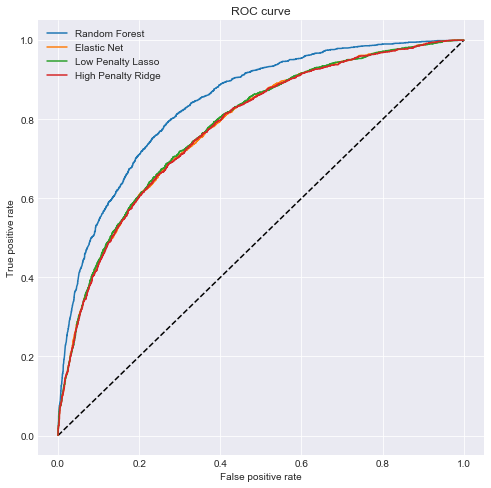

In [551]:
# Code adapted from example in sklearn documentation
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html

y_pred_rf = rf.predict_proba(X_hold_scale)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_hold, y_pred_rf)

y_pred_en = EN_final.predict_proba(X_hold_scale)[:, 1]
fpr_en, tpr_en, _ = roc_curve(y_hold, y_pred_en)

y_pred_l1 = l1_final.predict_proba(X_hold_scale)[:, 1]
fpr_l1, tpr_l1, _ = roc_curve(y_hold, y_pred_l1)

y_pred_l2 = l2_final.predict_proba(X_hold_scale)[:, 1]
fpr_l2, tpr_l2, _ = roc_curve(y_hold, y_pred_l2)


plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_en, tpr_en, label='Elastic Net')
plt.plot(fpr_l1, tpr_l1, label='Low Penalty Lasso')
plt.plot(fpr_l2, tpr_l2, label='High Penalty Ridge')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

The Random Forest model is again superior. All others perform pretty evenly. No clear bias for any classifier to predict active vs inactive.

# Recommendations

Based on the coefficients of the Logistic Regression features a couple of key suggestions:
- Explore why users aren't rating drivers.
    - These users had very low retention and the missing ratings suggest they weren't very engaged by Ultimate. Perhaps try to survey them for insights on improving service. Could also offer targeted promotions to these users to keep them active.
- King's Landing users are the likeliest to stay active, Astaporians the least.
    - What to do with this is a decision for management and possibly another study. How much market share does Ultimate have in King's Landing. Is it worth it to market there and increase activitiy from these better users or are there diminishing returns and it would be better direct marketing/pricing strategy towards fixing the lack of retention in Astapor. Or both.
- The more trips a user takes in the first 30 days, the likelier they are to stay active.
- Trying Ultimate Black in first month makes users likelier to stay active.
    - Both of the above require more investigation as these could just as easily be correlated as causal.
    - Users may stay active because they were likelier to have positive experience or form dependence on the service after enough initial trips **or** they could stay active because the type of users that take a lot of trips are the type that use a service like this and would be active regardless.
    - Same applies to Ultimate Black, these could be business travellors likely to use a service like Ultimate to begin with.
- Look into device type
    - iPhone users appeared likelier to stay active in some models, and that could well be the case but should not be assumed.
- Ask marketing department about promotional history regarding Signup Day.
    - Users who signed up later in the month were much less likely to stay active. This seems strange. Was there a promotion going on near the end of the month that brought a lot of signups but low retention?
- Explore Average Rating by Driver
    - Something very interesting could be going on here. This feature was near meaningless in the logistic models but was the most important for the most accurate model, the random forest. Could this be the difference in the accuracy gap between the models?